In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import numpy.lib.recfunctions as rf


While in development, MLA is not available via pip, so to import it, you need to add the location of the repository on your local machine to the python path.

In [2]:
import os
import sys
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install ~/mla
import mla

Processing ./mla
  Created wheel for mla-thejevans: filename=mla_thejevans-0.0.1-py3-none-any.whl size=28965 sha256=84593229b3322cb43670486966a467fc7e4b8919b3f158c720500fa7980b8abb
  Stored in directory: /tmp/pip-ephem-wheel-cache-m7zkbbkf/wheels/8c/48/b3/9140259f9b0da6559e99825e8695b86a19be0cff6f5377a4a1
Successfully built mla-thejevans


The `EventModel` class in this implementation uses data, simulation, and grl numpy arrays. We need to load in some arrays to do an analysis, options for CVS or npy files

['/home/jovyan/data/events/IC86_III_exp.csv', '/home/jovyan/data/events/IC86_II_exp.csv', '/home/jovyan/data/events/IC86_IV_exp.csv', '/home/jovyan/data/events/IC86_I_exp.csv', '/home/jovyan/data/events/IC86_VII_exp.csv', '/home/jovyan/data/events/IC86_VI_exp.csv', '/home/jovyan/data/events/IC86_V_exp.csv']
Keys available in data:
('time', 'logE', 'angErr', 'ra', 'dec', 'azi', 'zen')
Data NEvents: 897406
[(55694.99190986, 4.55, 0.00349066, 4.2346051 , -0.3948982 , 1.32062083, 1.17533962)
 (55694.99825262, 2.96, 0.01570796, 4.80188946,  0.68259827, 0.79477058, 2.25346441)
 (55695.00023207, 2.87, 0.00837758, 1.61364416,  0.08201302, 3.99456997, 1.65272208)
 ...
 (58307.96355617, 2.88, 0.00523599, 5.37783066,  0.74251542, 0.96755818, 2.31441131)
 (58307.96397167, 2.98, 0.00366519, 5.79796632,  0.78051124, 0.54958673, 2.35289582)
 (58307.97260325, 3.28, 0.00436332, 3.72294437,  0.0821701 , 2.6782601 , 1.65141308)]

Reduced the number of simulation events from  11595414 to 250000
Keys avail

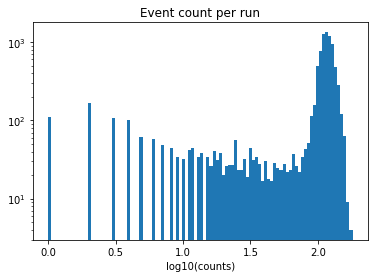

In [9]:
import glob
def read_npy(filelist):
    data = []
    for f in sorted(filelist):
        x = np.load(f)
        if len(data) == 0: data = x.copy()
        else: data = np.concatenate([data, x])
    return data

def read_csv(filelist):
    np_dtype = np.float64
    my_names = ['time', 'logE', 'angErr', 'ra', 'dec', 'azi', 'zen']
    convert = lambda x: np.radians(float(x))
    data = []
    for f in sorted(filelist):
        x = np.genfromtxt(f, names=my_names, dtype=np_dtype, skip_header = 1,
                        converters={2: convert, 3: convert, 4: convert, 5: convert, 6: convert})
        if len(data) == 0: data = x.copy()
        else: data = np.concatenate([data, x])
    return data[np.argsort(data['time'])]

def read_uptime_csv(filelist):
    np_dtype = np.float64
    my_names = ['start', 'stop']
    data = []
    for f in sorted(filelist):
        x = np.genfromtxt(f, names=my_names, dtype=np_dtype, skip_header = 1)
        if len(data) == 0: data = x.copy()
        else: data = np.concatenate([data, x])
    return data[np.argsort(data['start'])]

def read_mc(file, n_keep = 50000):
    sim = np.load(file)
    # Reduce the number of events in the simulation
    # to a manageable level.
    N = len(sim)
    sim = np.random.choice(sim, n_keep)    # cut down to n_keep events
    sim['ow'] /= float(n_keep)/float(N)    # correct the weights
    print("Reduced the number of simulation events from ",
         "{} to {}".format(N, len(sim)))
    # Show the possible keys available here:
    print("Keys available in simulation:")
    print(sorted(sim.dtype.names))
    print()
    return sim

# Fix the 7yr data release good run lists, add livetime, events per run, and a psudeo-run number
def fix_grl(data,raw_grl):
    grl_run_index, counts = np.unique(np.searchsorted(raw_grl['start'], data['time']), return_counts=True)
    pad_counts = np.zeros(len(raw_grl),dtype=int)
    for idx,thiscnt in zip(grl_run_index,counts):
        #print(idx,thiscnt)
        pad_counts[idx-1] = int(thiscnt)
    #print(pad_counts)
    plt.hist(np.log10(counts),100,log=True)
    plt.xlabel('log10(counts)')
    plt.title('Event count per run')

    livetime = raw_grl['stop'] - raw_grl['start']
    run_number = range(len(raw_grl))
    new_grl = rf.append_fields(raw_grl, ['events','livetime','run'], [pad_counts,livetime,run_number])
    return new_grl

#1 year data file from npy file
DATA_PATH = "/home/jovyan/old_npy_data"
data_file_1 = DATA_PATH + "/IC86_*_exp.npy"
#data = read_npy(glob.glob(data_file_1))

# 7 year data from CSV files
DATA2_PATH = "/home/jovyan/data"
data_files = DATA2_PATH + "/events/IC86_*_exp.csv"
print(glob.glob(data_files))
data = read_csv(glob.glob(data_files))

print("Keys available in data:")
print(data.dtype.names)
print('Data NEvents:',len(data))
print(data)
print()

# Read in the MC files - these are the same regardless of data files 
sim_files = DATA_PATH + "/IC86_2012_MC.npy"
sim = read_mc(sim_files, n_keep=250000)
print('Sim NEvents:',len(sim))
print(sim.dtype.names)
print()

# Read in the GRL file
# 1 year data
#grl = np.load(DATA_PATH + "/IC86_2012_GRL.npy")
# 7 yr data
grl_files = DATA2_PATH + "/uptime/IC86_*_exp.csv"
raw_grl = read_uptime_csv(glob.glob(grl_files))
grl = fix_grl(data=data,raw_grl=raw_grl)
print("Keys available in GRL:")
print(grl.dtype.names)
print(grl)

To start an analysis, you need a `Source`, an `EventModel`, and a `TestStatistic`. Let's start with the `Source`. Currently, our software supports point-source objects only. 

In [47]:
#PSO J0309+27
#RA 03h 09m 47.49s
#DEC+27° 17′ 57.31″
#Calculate in degreess
ra_pso = (3+(9+(47.49/60.0))/60.0)*(360.0/24.0)
dec_pso = 27.0 +(17+(57.31/60.0))/60.0

source2 = mla.sources.Source(
    name="PSO J0309",
    ra=np.deg2rad(ra_pso),
    dec=np.deg2rad(dec_pso)
)

source = mla.sources.Source(
    name="TXS",
    ra=np.deg2rad(77.3583),
    dec=np.deg2rad(5.6931)
)

Next, we need an `EventModel`. This is an object that holds everything that will be implemented by Michael's public data package. Once that is ready, We will make an `EventModel` object that interfaces with it, leaving the rest of our package the same.

The only `EventModel` that is currently ready-to-go is the `I3EventModel` class. Building this object is probably the most complicated part of starting an analysis. Here is a list of parameters that it takes:

Required:
- `source`: A `Source` object
- `data`: A numpy array of real events to be used for background event generation
- `sim`: A numpy array of monte-carlo events to be used for signal event generation
- `grl`: A numpy array of good runs to be used to select times of generated events
- `gamma`: A number representing the assumed spectral index for calculating simulation event weights
- `background_time_profile`: An object that is a subclass of `GenericProfile` representing the temporal PDF of the background events
- `signal_time_profile`: A similar object for the signal events

Optional:
- `sampling_width`: The width in radians of a declination band used to filter out events far from the source to reduce computation time (default: 3 deg)
- `background_sin_dec_bins`: Either a number of equally spaced bins to use, or an array of bin edges for creating a background spatial pdf in sin(declination) (default: 500)
- `background_window`: A length of time (in MJD) to use to sample background events from prior to the time window of interest. Useful for analyses with short time windows that likely have more signal than usual. (default: 14)
- `withinwindow`: A flag for choosing whether to use the events in the time window of interest as background, or to use the value in `background_window` to select a differnt background window. (default: False)
- `signal_sin_dec_bins`: Either a number of equally spaced bins to use, or an array of bin edges for creating a grid of energy splines (default: 50)
- `log_energy_bins`: Either a number of equally spaced bins to use, or an array of bin edges for creating a grid of energy splines (default: 50)
- `gamma_bins`: Either a number of equally spaced bins to use, or an array of bin edges for creating a spline interpolation at each bin in the grid (default: 50)
- `verbose`: A flag for printing status information while building the event model. (default: False)

Before we can build an `I3EventModel`, we need time profiles for signal and background. We have these built-in options for time profiles:
- `UniformProfile`: Takes a `start` in MJD and a `length` in MJD and represents a uniform distribution between those times.
- `GaussProfile`: Takes a `mean` in MJD and a `sigma` in MJD and represents a normal distribution with those parameters.
- `CustomProfile`: Takes a 1D-histogram in time as the shape of the pdf and an `offset` as a time shift of the histogram and represents a step-function distribution with the given parameters.

In [48]:
# TXS analysis for 158 days at known published neutrino flare time
#start = 56224
#length = 158

# Use all the data.  Use the GRL info
start = grl['start'][0]
length = grl[len(grl)-1][1] - start

print('Time window of: ', length, ' starting at MJD:', start)


background_time_profile = mla.time_profiles.UniformProfile(start, length)
signal_time_profile = mla.time_profiles.UniformProfile(start, length)

model = mla.models.I3EventModel(
    source=source,
    data=data,
    sim=sim,
    grl=grl,
    gamma=-2,
    background_time_profile=background_time_profile,
    signal_time_profile=signal_time_profile,
    sampling_width=np.radians(5),
    withinwindow=True,
)

Time window of:  2614.0918749999983  starting at MJD: 55694.99047453


/opt/conda/lib/python3.8/site-packages/mla/models.py:155: RuntimeWarning: invalid value encountered in greater
  good = np.isfinite(ratio[i]) & (ratio[i] > 0)


Finally, we need a `TestStatistic`. Currently, only a standard signal-over-background LLH test statistic is defined, `LLHTestStatistic`. This class is very flexible, though. During initialization, you give a list of likelihood terms as parameters. You can give as many or as few as you like, and in whatever order you like. Currently there are four available terms:

- `SpatialTerm`: Takes no parameters. Uses the spatial pdfs defined in the `EventModel` to calculate a spatial signal-over-background ratio (sob)
- `TimeTerm`: Takes as parameters both a signal and background time profile so that you can attempt to fit using different profiles than you gave to the `EventModel` for injecting events. Currently, this term allows for the signal time profile parameters to be fitting parameters, but not the background parameters.
- `I3EnergyTerm`: Only works with `I3EventModel` models. Takes a default spectral index (`gamma`) as a parameter. This value can be a fitting parameter.
- `threeml.test_statistics.ThreeMLEnergyTerm`: Only works with `threeml.models.ThreeMLEventModel` models. Takes no parameters.

In [49]:
bg_fit_time_pro = copy.deepcopy(background_time_profile)
sig_fit_time_pro = copy.deepcopy(signal_time_profile)
        
ts = mla.test_statistics.LLHTestStatistic([
    mla.test_statistics.SpatialTerm(),
    mla.test_statistics.TimeTerm(
        bg_fit_time_pro,
        sig_fit_time_pro,
    ),
    mla.test_statistics.I3EnergyTerm(gamma=-2),
])

The `LLHTestStatistic` class also has $n_s$ as an optional fitting parameter. If you do not choose to fit it, the class will use a newton methods approach to find the best $n_s$ in every fitting step, which is generally faster.

From here, we can put together what we have built into an `Analysis` object. The analysis should be static object to be shared between threads in multithreaded applications or sent as a pickle file to cluster jobs. Initialization is straightforward:

In [50]:
analysis = mla.analysis.Analysis(
    model=model,
    test_statistic=ts,
    source=source,
)

Now that you have an `Analysis`, you can start on your analysis!

There are four basic functions available in the `analysis` module for this:
- `produce_trial`: Takes an `Analysis` and optional parameters for injecting signal, either a `flux_norm` (time-integrated flux normalization) or `n_signal_observed` to set the number of signal events injected. Returns a numpy array of combined signal and background events.
- `evaluate_ts`: Takes an `Analysis`, `events`, and `params` (manually-set fitting parameters). Returns a float test statistic value for the given events and parameters.
- `minimize_ts`: Takes an `Analysis`, `events`, and optionally `test_params` and `bounds`. Uses an optional `minimizer` (`scipy.optimize.minimize` by default) to minimize the `test_params` within the `bounds`. Returns a dictionary of the bests test statistic value and the best-fit parameters (always returns best-fit $n_s$, even if it is not a fitting parameter).
- `produce_and_minimize`: Takes an `Analysis`, a number of trials to run (`n_trials`), and optional parameters for `produce_trial` and `minimize_ts`. Returns a list of `minimize_ts` results, one for each trial.

Parameters should be a structured numpy array, with `dtype` names matching the expected variable names in the test statistic terms. Examples:
- for any test statistic: `ns`
- for `I3EnergyTerm`: `gamma`
- for `TimeTerm`: `mean`, `sigma`, `start`, `length`, `offset`

Let's produce a trial and then minimize the test statistic:

896774
[(57920.24137745995, 3.43, 0.030892327760299633, 1.7535233435601523, 0.7001562827300453, 1.4768976130376017, 2.2711620490351807, 0.6443372109950067)
 (58261.48766179178, 4.5, 0.014486232791552934, 3.3699891789337024, -0.17118189303560383, 2.897333824773187, 1.3982530769427373, -0.17034708640485413)
 (57987.62300731958, 3.23, 0.005061454830783556, 2.6221129438179758, 0.06946410422937431, 4.598052461086541, 1.64055713699711, 0.06940825395785814)
 ...
 (58267.51456729954, 3.711022054165801, 0.004592745739467237, 1.3435987817216295, 0.09760607796449461, 0.9462341506748317, 1.583354336850032, 0.09745117045959954)
 (57251.7240736355, 3.405629903681809, 0.0073794199171741985, 1.3554494295979527, 0.09898887454493291, 4.25619081649096, 1.7058946248447784, 0.09882729174527388)
 (56078.985396328186, 2.752351977712173, 0.007275459052215151, 1.3615166950284965, 0.10319638926840265, 1.507516576985822, 1.6178758568655531, 0.1030133218732655)]
('time', 'logE', 'angErr', 'ra', 'dec', 'azi', 'zen

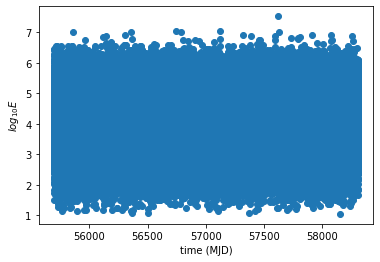

[(0.69538019, 3.51876369)]


In [101]:
trial = mla.analysis.produce_trial(
    analysis,
    #n_signal_observed=20,
    flux_norm=1e-11
)
print(len(trial))
print(trial)
print(trial.dtype.names)
# Plot the trial events
plt.scatter(trial['time'], trial['logE'])
plt.xlabel('time (MJD)')
plt.ylabel(r'$log_{10}E$')
plt.show()

# Generate parameter array for minimizing
## Here: minimize both spectral index (gamma) and n_s
#test_params = mla.generate_params(
#            gamma=-2,
#            ns=90,
#        )
#bounds = [(-4, -1), (0, 150)]

## Here: just miminize n_s
test_params = mla.generate_params(
            ns=90
)
bounds = [(0, 150)]

result = mla.analysis.minimize_ts(
    analysis=analysis,
    events=trial,
    bounds=bounds,
    test_params=test_params,
    as_array=True,

)

print(result)
# result = TS , # interesting events

Now, lets use `produce_and_minimize` to do the same with 10 trials:

In [102]:
results = mla.produce_and_minimize(
    analysis=analysis,
    n_trials=10,
    #n_signal_observed=50,
    flux_norm=1e-11,
    bounds=bounds,
    test_params=test_params,
    as_array=True,
)

for result in results:
    print(result)
    
(ts,ns) = zip(*results)
print(np.mean(ts),np.mean(ns))

(28.20257468, 14.2782846)
(5.83820101, 4.18570363)
(25.51027111, 13.93286369)
(8.67913988, 5.93428896)
(0., 0.)
(1.39565443, 6.34866246)
(32.14558096, 14.71660623)
(0., 0.)
(3.36245786, 2.90056947)
(17.59840748, 10.42325806)
12.273228740812339 7.272023709694707


In [139]:
# Produce and minimize 100 trials, then plot the ts distribution

#exponent1=-11.25
exponent2=-10.75
exponent3=-10.5
exponent4=-10.25

#print("Producing 1000 trials, flux normalization = 10^-11.25")
#best_fit_arr_1125 = mla.produce_and_minimize(
#    analysis=analysis,
#    n_trials=100,
#    flux_norm=10**exponent1,
#    #n_signal_observed=50,
#    bounds=bounds,
#    test_params=test_params,
#    as_array=True,
#)

print("Producing 1000 trials, flux normalization = 10^-11")
best_fit_arr_11 = mla.produce_and_minimize(
    analysis=analysis,
    n_trials=1000,
    flux_norm=1e-11,
    #n_signal_observed=50,
    bounds=bounds,
    test_params=test_params,
    as_array=True,
)

print("Producing 1000 trials, flux normalization = 10^-10.75")
best_fit_arr_1075 = mla.produce_and_minimize(
    analysis=analysis,
    n_trials=1000,
    flux_norm=10**exponent2,
    #n_signal_observed=10,
    bounds=bounds,
    test_params=test_params,
    as_array=True,
)

print("Producing 1000 trials, flux normalization = 10^-10.5")
best_fit_arr_105 = mla.produce_and_minimize(
    analysis=analysis,
    n_trials=1000,
    flux_norm=10**exponent3,
    #n_signal_observed=5,
    bounds=bounds,
    test_params=test_params,
    as_array=True,
)

print("Producing 1000 trials, flux normalization = 10^-10.25")
best_fit_arr_1025 = mla.produce_and_minimize(
    analysis=analysis,
    n_trials=1000,
    flux_norm=10**exponent4,
    #n_signal_observed=10,
    bounds=bounds,
    test_params=test_params,
    as_array=True,
)

print("Producing 1000 trials, flux normalization = 10^-10")
best_fit_arr_10 = mla.produce_and_minimize(
    analysis=analysis,
    n_trials=1000,
    flux_norm=1e-10,
    #n_signal_observed=50,
    bounds=bounds,
    test_params=test_params,
    as_array=True,
)

print("Producing 5000 bg only trials")
best_fit_arr_bg = mla.produce_and_minimize(
    analysis=analysis,
    n_trials=5000,
    #n_signal_observed=0,
    flux_norm=0,
    bounds=bounds,
    test_params=test_params,
    as_array=True,
)


Producing 1000 trials, flux normalization = 10^-11
Producing 1000 trials, flux normalization = 10^-10.75
Producing 1000 trials, flux normalization = 10^-10.5
Producing 1000 trials, flux normalization = 10^-10.25
Producing 1000 trials, flux normalization = 10^-10
Producing 5000 bg only trials


In [140]:
ts_bg, ns_bg = zip(*best_fit_arr_bg)
#ts_1125, ns_1125 = zip(*best_fit_arr_1125)
ts_11, ns_11 = zip(*best_fit_arr_11)
ts_1075, ns_1075 = zip(*best_fit_arr_1075)
ts_105, ns_105 = zip(*best_fit_arr_105)
ts_1025, ns_1025 = zip(*best_fit_arr_1025)
ts_10, ns_10 = zip(*best_fit_arr_10)
#print(ts_50,ns_50)

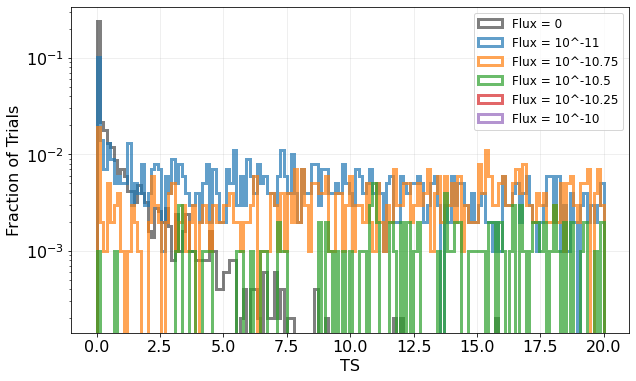

In [170]:
# Plot the signal and background LLHs
fig, ax = plt.subplots(figsize=(10,6))
bins = np.linspace(0, 20, 150)

ax.hist(ts_bg,
        bins = bins,
        weights = np.ones_like(ts_bg)/len(ts_bg),
        histtype = 'step',
        color = 'k',
        linewidth = 3,
        alpha=0.5,
        label = r'Flux = 0',
       )

#ax.hist(ts_1125,
#        bins = bins,
#        weights = np.ones_like(ts_1125)/len(ts_1125),
#        histtype = 'step',
#        linewidth = 3,
#        alpha = 0.7,
#        label = r'Flux = 10^-11.25')

ax.hist(ts_11,
        bins = bins,
        weights = np.ones_like(ts_11)/len(ts_11),
        histtype = 'step',
        linewidth = 3,
        alpha = 0.7,
        label = r'Flux = 10^-11')

ax.hist(ts_1075,
        bins = bins,
        weights = np.ones_like(ts_1075)/len(ts_1075),
        histtype = 'step',
        linewidth = 3,
        alpha = 0.7,
        label = r'Flux = 10^-10.75')

ax.hist(ts_105,
        bins = bins,
        weights = np.ones_like(ts_105)/len(ts_105),
        histtype = 'step',
        linewidth = 3,
        alpha = 0.7,
        label = r'Flux = 10^-10.5')

ax.hist(ts_1025,
        bins = bins,
        weights = np.ones_like(ts_1025)/len(ts_1025),
        histtype = 'step',
        linewidth = 3,
        alpha = 0.7,
        label = r'Flux = 10^-10.25')

ax.hist(ts_10,
        bins = bins,
        weights = np.ones_like(ts_10)/len(ts_10),
        histtype = 'step',
        linewidth = 3,
        alpha = 0.7,
        label = r'Flux = 10^-10')

ax.legend(loc='upper right', fontsize=12,)
plt.yscale('log')
ax.grid(alpha=0.25)
#ax.set_xlim(bins.min(), bins.max())
ax.set_xlabel("TS", fontsize=16)
ax.set_ylabel("Fraction of Trials", fontsize=16)
ax.tick_params(which='both', labelsize=16)

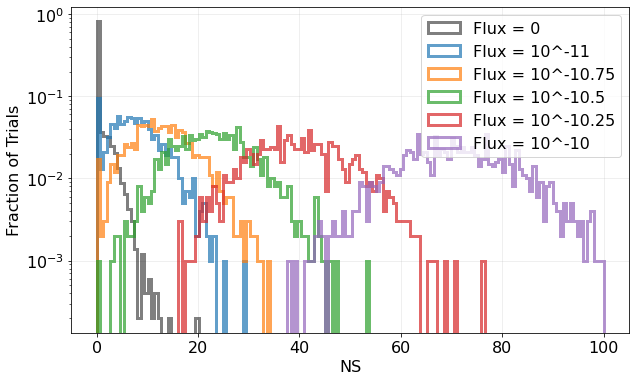

In [156]:
# Plot the best fit ns
fig, ax = plt.subplots(figsize=(10,6))
bins = np.linspace(0, 100, 150)

ax.hist(ns_bg,
        bins = bins,
        weights = np.ones_like(ns_bg)/len(ns_bg),
        histtype = 'step',
        color = 'k',
        linewidth = 3,
        alpha=0.5,
        label = r'Flux = 0',
       )

#ax.hist(ns_1125,
#       bins = bins,
#       weights = np.ones_like(ns_1125)/len(ns_1125),
#       histtype = 'step',
#        linewidth = 3,
#        alpha = 0.7,
#        label = r'Flux = 10^-11.25')

ax.hist(ns_11,
        bins = bins,
        weights = np.ones_like(ns_11)/len(ns_11),
        histtype = 'step',
        linewidth = 3,
        alpha = 0.7,
        label = r'Flux = 10^-11')

ax.hist(ns_1075,
        bins = bins,
        weights = np.ones_like(ns_1075)/len(ns_1075),
        histtype = 'step',
        linewidth = 3,
        alpha = 0.7,
        label = r'Flux = 10^-10.75')

ax.hist(ns_105,
        bins = bins,
        weights = np.ones_like(ns_105)/len(ns_105),
        histtype = 'step',
        linewidth = 3,
        alpha = 0.7,
        label = r'Flux = 10^-10.5')

ax.hist(ns_1025,
        bins = bins,
        weights = np.ones_like(ns_1025)/len(ns_1025),
        histtype = 'step',
        linewidth = 3,
        alpha = 0.7,
        label = r'Flux = 10^-10.25')

ax.hist(ns_10,
        bins = bins,
        weights = np.ones_like(ns_10)/len(ns_10),
        histtype = 'step',
        linewidth = 3,
        alpha = 0.7,
        label = r'Flux = 10^-10')

ax.legend(loc='upper right', fontsize=16,)
plt.yscale('log')
ax.grid(alpha=0.25)
#ax.set_xlim(bins.min(), bins.max())
ax.set_xlabel("NS", fontsize=16)
ax.set_ylabel("Fraction of Trials", fontsize=16)
ax.tick_params(which='both', labelsize=16)

Things to do:
* (DONE) bring in 7 yrs of data (Erik will provide conversion from csv to npy tool)
* currently, this uses a 158d time window, want to use ALL data in a uniform time profile.
* n_injected here is as "n events" -> option to use signal normalization

Starting to setup an analysis
* background only TS distributions.
* signal injections (flux vs. n_injected above)
* find point where you make "discovery" and are "sensitive"
* then look at real data.  What is your TS, where does it land relative to these distributions?  Did you discovery anything?

In [151]:
# Use this bit of code to save the numpy arrays outputted from trial runs as a '.npy' file
# You will have to import 'os' and both the 'save' and 'load' libraries from the numpy library either
# at the top with the others or here before you run the code to have both save and load functionality.
# You can copy and paste from below or just uncomment:

import os
from numpy import save
from numpy import load

# Use the 'save()' funciton to save. The first argument is the filename and second is the numpy array
# you wish to save. 'SAVEPATH' defines the path to save the file, 'RUNFOLDER' should be a unique name
# to identify the run, and 'FILENAME' is the name of the particular file.
# I've been using the following convention for naming files:

# XXX##_*** , where:
    # XXX is:
        # BGD for background
        # INJ for trials with n injections
        # FLX for trials with flux norms
    # ## is:
        # 00 for BGD
        # the number of injections for INJ; e.g. n_inj=10 --> ## = 10
        # the negative exponent of the flux norm for FLX, where the first two numbers are before the decimal and the rest is after
            # e.g. flux_norm = 1e-11 --> ## = 11
            # e.g. flux_norm = 1e-10.125 --> ## = 10125
    # *** is the number of trials in that run

# Make a new folder for each run and name it in a way we can identify it.
# 'TARGETARRAY' is the unzipped numpy array you want to save. Just copy and paste the array you want to save.
# Repeat this code with the same runfolder for each array of the run.

SAVEPATH = './TrialData/'
RUNFOLDER = 'RUN1/'
FILENAME = 'FLX10_1000test'
TARGETARRAY = best_fit_arr_10

#This just creates the runfolder if it doesn't already exist
if not os.path.exists(SAVEPATH+RUNFOLDER):
    os.makedirs(SAVEPATH+RUNFOLDER)

save(SAVEPATH+RUNFOLDER+FILENAME, TARGETARRAY)

In [172]:
#finding 10% and mean of certain trials that are closer to the background (contestants for sensitivity)
ten_ts_11 = np.percentile(ts_11,10)
mean_ts_11 = np.mean(ts_11)

ten_ts_1075 = np.percentile(ts_1075,10)
mean_ts_1075 = np.mean(ts_1075)

#finding the mean of other trials farther from the backgrounf (contestants for 3 sigma)
mean_ts_105 = np.mean(ts_105)

mean_ts_1025 = np.mean(ts_1025)

mean_ts_10 = np.mean(ts_10)

#finding 3 sigma and mean of bg
mean_ts_bg = np.mean(ts_bg) 
threesig_ts_bg = np.percentile(ts_bg,99.85)

# Print the results
print('The mean and 3 sigma of the background TS: ')
print(mean_ts_bg, threesig_ts_bg)

print('\n')
print('The mean and 10% value of flux 1e-11: ')
print(mean_ts_11,ten_ts_11)

print('\n')
print('The mean and 10% value of flux 1e-10.75: ')
print(mean_ts_1075,ten_ts_1075)

print('\n')
print('The mean of flux 1e-10.5: ')
print(mean_ts_105)

print('\n')
print('The mean of flux 1e-10.25: ')
print(mean_ts_1025)

print('\n')
print('The mean of flux 1e-10: ')
print(mean_ts_10)

print('\n')
print('For a sensitivity level, the 10% of a certain flux level will be the mean of the background data. ')
print('For a 3 sigma discovery level, the mean of a certain flux level will be the 99.85% of the background data')

#print('\n\n\nThe mean, 50th, and 10th percentile of the ' + TRIALNAME + ' trial set TS and NS: \n TS')
#print(mean_ts_trial, fifty_ts_trial, ten_ts_trial)
#print('\n NS')
#print(mean_ns_trial, fifty_ns_trial, ten_ns_trial)

The mean and 3 sigma of the background TS: 
0.2474038010135124 7.452734319592729


The mean and 10% value of flux 1e-11: 
12.162069881114537 0.06975077002356632


The mean and 10% value of flux 1e-10.75: 
23.609465070797096 5.170953632041312


The mean of flux 1e-10.5: 
49.00648164298869


The mean of flux 1e-10.25: 
102.91181331684146


The mean of flux 1e-10: 
215.77392467396342


For a sensitivity level, the 10% of a certain flux level will be the mean of the background data. 
For a 3 sigma discovery level, the mean of a certain flux level will be the 99.85% of the background data


In [168]:
bg_max = np.amax(ts_bg)
print(bg_max)
bg_mean_maybe = 1/bg_max
print(bg_mean_maybe)

15.707510154111226
0.0636638136909473
